In [1]:
# 基本的なライブラリ
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# 描画ライブラリ
import graphviz
from dtreeviz.trees import *

# models
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析
from lightgbm import LGBMClassifier
import xgboost as xgb

# tuning
import optuna

import config
import functions

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced.pkl"
)

/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


# 最適化

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

### LogisticRegression

0it [00:00, ?it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.375


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.898148,0.5,0.898148,0.375


subgroup:  Her2


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.4


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.985075,0.727273,0.985075,0.4


subgroup:  LumA


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.380952380952381


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.885417,0.35,0.885417,0.380952


1it [00:11, 11.10s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


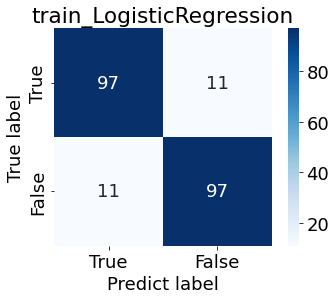

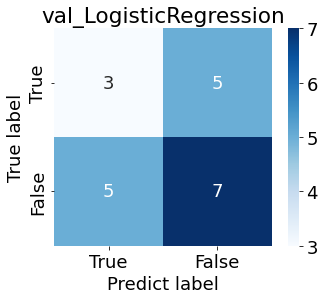

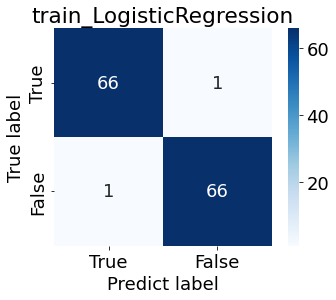

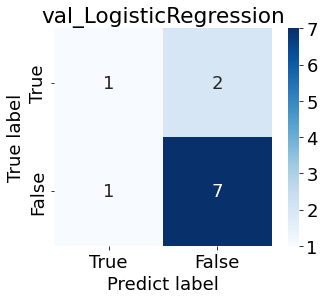

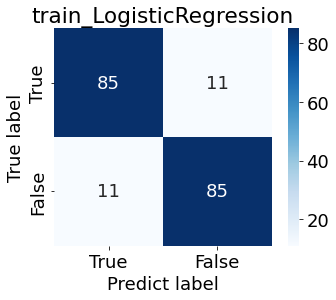

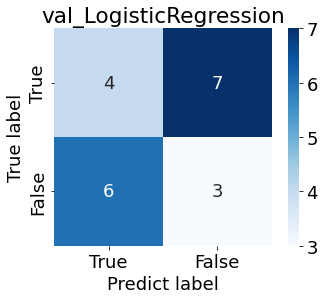

In [3]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-5, 1e5),
        "max_iter": 1000,
        "solver": "liblinear",
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = LogisticRegression(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            # init model
            clf = LogisticRegression()

            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            functions.make_dir(input_file_path)
            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue
            X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
            X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "penalty": study.best_params["penalty"],
                "C": study.best_params["C"],
                "max_iter": 1000,
                "solver": "liblinear",
                "class_weight": "balanced",
                "random_state": SEED,
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifiers=[clf],
                    plot=True,
                )
            )

## SVM(linear)

0it [00:00, ?it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


  0%|          | 0/1000 [00:00<?, ?it/s]

{'C': 1.4000217200207106}
0.35294117647058826


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.888889,0.45,0.889908,0.352941


subgroup:  Her2


  0%|          | 0/1000 [00:00<?, ?it/s]

{'C': 543.4053983860236}
0.4


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.985075,0.727273,0.985075,0.4


subgroup:  LumA


  0%|          | 0/1000 [00:00<?, ?it/s]

{'C': 543.4053983860236}
0.380952380952381


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.90625,0.35,0.907216,0.380952


1it [14:07, 847.11s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


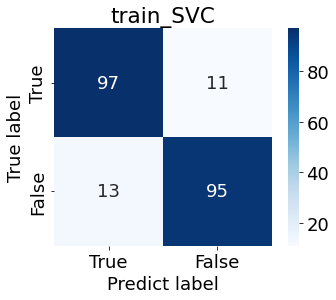

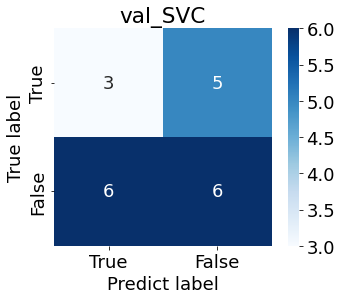

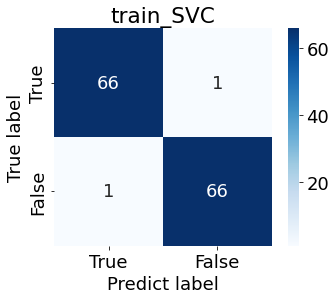

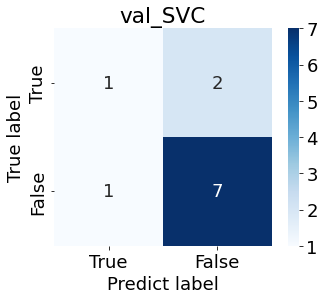

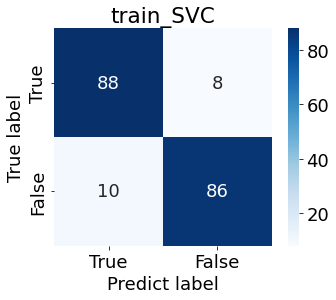

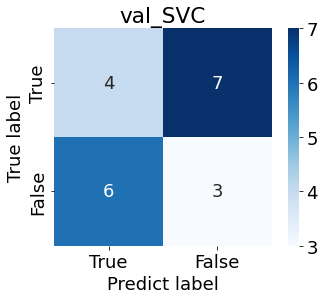

In [4]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-3, 1e3),
        "kernel": "linear",
        "max_iter": -1,
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = SVC(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            # init model
            clf = SVC()

            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            functions.make_dir(input_file_path)
            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue
            X_train, y_train = list_train[0], list_train[1]
            X_val, y_val = list_val[0], list_val[1]

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "C": study.best_params["C"],
                "kernel": "linear",
                "max_iter": -1,
                "class_weight": "balanced",
                "random_state": SEED,
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifiers=[clf],
                    plot=True,
                )
            )

## Random Forest

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 100),
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("#####" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            # init model
            clf = RandomForestClassifier()

            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            functions.make_dir(input_file_path)
            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue
            X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
            X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "n_estimators": study.best_params["n_estimators"],
                "max_depth": study.best_params["max_depth"],
                "max_leaf_nodes": study.best_params["max_leaf_nodes"],
                "class_weight": "balanced",
                "random_state": SEED,
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifier_names=[clf.__class__.__name__],
                    classifiers=[clf],
                    plot=True,
                )
            )

## LGMB

In [5]:
def objective(trial):
    params = {
        "boosting_type ": trial.suggest_categorical(
            "boosting_type", ["gbdt", "dart", "goss", "rf"]
        ),
        "num_leaves ": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "algorithm": trial.suggest_categorical(
            "algorithm", ["ball_tree", "kd_tree", "brute"]
        ),
        "leaf_size": trial.suggest_int("leaf_size", 2, 60),
        "p": trial.suggest_int("p", 1, 2),
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            # init model
            clf = LGBMClassifier()

            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            functions.make_dir(input_file_path)
            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue
            X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
            X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "n_neighbors": study.best_params["n_neighbors"],
                "weights": study.best_params["weights"],
                "algorithm": study.best_params["algorithm"],
                "leaf_size": study.best_params["leaf_size"],
                "p": study.best_params["p"],
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifier_names=[clf.__class__.__name__],
                    classifiers=[clf],
                    plot=True,
                )
            )

0it [00:00, ?it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


  0%|          | 0/1000 [00:00<?, ?it/s]

[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: algorithm
[LightGBM] [Warning] Unknown parameter: distance
[LightGBM] [Warning] Unknown parameter: p
[LightGBM] [Warning] Unknown parameter: rf
[LightGBM] [Warning] Unknown parameter: leaf_size
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: algorithm
[LightGBM] [Warning] Unknown parameter: p
[LightGBM] [Warning] Unknown parameter: rf
[LightGBM] [Warning] Unknown parameter: leaf_size
[LightGBM] [Warning] Unknown parameter: uniform
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting

0it [00:26, ?it/s]

[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: algorithm
[LightGBM] [Warning] Unknown parameter: p
[LightGBM] [Warning] Unknown parameter: goss
[LightGBM] [Warning] Unknown parameter: leaf_size
[LightGBM] [Warning] Unknown parameter: uniform
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: algorithm
[LightGBM] [Warning] Unknown parameter: p
[LightGBM] [Warning] Unknown parameter: leaf_size
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: uniform
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boost

KeyError: 'n_neighbors'

## kNN

0it [00:00, ?it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


  0%|          | 0/10000 [00:00<?, ?it/s]

{'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 17, 'p': 2}
0.5333333333333333



0it [00:00, ?it/s]
1it [00:00,  4.76it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
KNeighborsClassifier,0.916667,0.65,0.909091,0.533333


subgroup:  Her2


  0%|          | 0/10000 [00:00<?, ?it/s]

{'n_neighbors': 16, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 59, 'p': 1}
0.6666666666666666



1it [00:00, 11.02it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
KNeighborsClassifier,0.925373,0.818182,0.927536,0.666667


subgroup:  LumA


  0%|          | 0/10000 [00:00<?, ?it/s]

{'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 5, 'p': 2}
0.5



1it [00:00, 10.78it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
KNeighborsClassifier,1.0,0.5,1.0,0.5


1it [02:20, 140.17s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


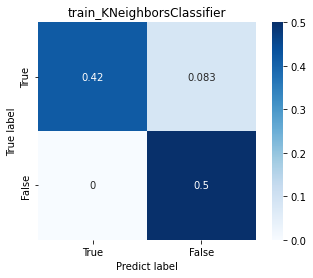

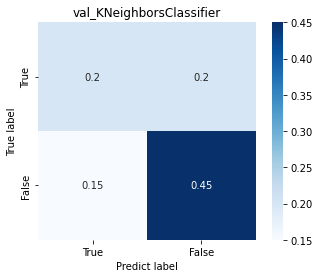

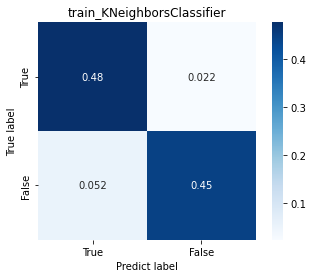

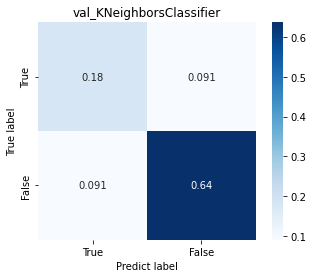

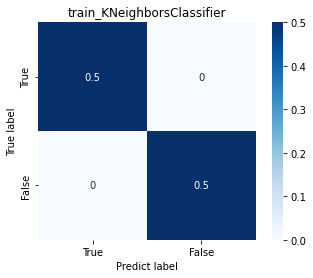

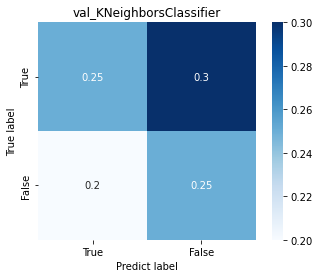

In [10]:
def objective(trial):
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 2, 50),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "algorithm": trial.suggest_categorical(
            "algorithm", ["ball_tree", "kd_tree", "brute"]
        ),
        "leaf_size": trial.suggest_int("leaf_size", 2, 60),
        "p": trial.suggest_int("p", 1, 2),
    }

    clf = KNeighborsClassifier(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            # init model
            clf = KNeighborsClassifier()

            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            functions.make_dir(input_file_path)
            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue
            X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
            X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "n_neighbors": study.best_params["n_neighbors"],
                "weights": study.best_params["weights"],
                "algorithm": study.best_params["algorithm"],
                "leaf_size": study.best_params["leaf_size"],
                "p": study.best_params["p"],
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifier_names=[clf.__class__.__name__],
                    classifiers=[clf],
                    plot=True,
                )
            )